## <b> [3단계] AI 모델링
---

## 1, 2 단계에서 진행하신 내용을 아래에 그대로 진행해주세요.

---

# <b>Step 0. 라이브러리 import 및 데이터 불러오기
### **가. 라이브러리 import**

* 데이터 프레임 관련 라이브러리

In [1]:
#라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### **나.  학습데이터 불러오기**
- label 0, 1 변경
- train 데이터의 결측치 2개 행 삭제

In [2]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_df.shape,train_df.shape, test_x.shape

((3664, 24), (3664, 24), (2441, 24))

In [3]:
train_df = train_df.dropna()
train_df.isnull().sum()

url_len                    0
url_num_hyphens_dom        0
url_path_len               0
url_domain_len             0
url_hostname_len           0
url_num_dots               0
url_num_underscores        0
url_query_len              0
url_num_query_para         0
url_ip_present             0
url_entropy                0
url_chinese_present        0
url_port                   0
html_num_tags('iframe')    0
html_num_tags('script')    0
html_num_tags('embed')     0
html_num_tags('object')    0
html_num_tags('div')       0
html_num_tags('head')      0
html_num_tags('body')      0
html_num_tags('form')      0
html_num_tags('a')         0
html_num_tags('applet')    0
label                      0
dtype: int64

In [4]:
train_df.shape

(3662, 24)

In [5]:
train_df['label'] = train_df['label'].replace({'benign' : 0, 'malicious' : 1})

### **다.  데이터 전처리**
- 값이 0밖에 없는 특징 제거
    1. url_chinese_present
    2. html_num_tags('applet')
- 상관관계가 높은 변수 제거
    - url_hostname_len 과 url_domain_len : 0.998 -> label과 상관관계가 더 높은 url_hostname_len 만 살리기
    - url_len 과 url_path_len : 0.944 -> label과 상관관계가 더 높은 url_path_len 만 살리기
    - url_query_len_is 와 url_num_query_para_is : 0.914 : label과 상관관계가 더 높은 url_query_len_is 만 살리기
- 중복 데이터 제거
- test 데이터 결측치 -> 중앙값으로 대체

#### 값이 0밖에 없는 특징 제거
1. url_chinese_present
2. html_num_tags('applet')

In [6]:
train_df = train_df.drop(["url_chinese_present", "html_num_tags('applet')"], axis=1)
test_x = test_x.drop(["url_chinese_present", "html_num_tags('applet')"], axis=1)

#### 상관관계가 높은 변수 제거
- url_hostname_len 과 url_domain_len : 0.998 -> label과 상관관계가 더 높은 url_hostname_len 만 살리기
- url_len 과 url_path_len : 0.944 -> label과 상관관계가 더 높은 url_path_len 만 살리기
- url_query_len_is 와 url_num_query_para_is : 0.914 : label과 상관관계가 더 높은 url_query_len_is 만 살리기

In [7]:
train_df = train_df.drop(["url_domain_len", "url_path_len", "url_num_query_para"], axis=1)
test_x = test_x.drop(["url_domain_len", "url_path_len", "url_num_query_para"], axis=1)

#### 중복 데이터 제거

In [8]:
train_df = train_df.drop_duplicates()

#### test 데이터 결측치 처리
- 평균으로 대체

In [9]:
test_x.isnull().sum()

id                           0
url_len                      0
url_num_hyphens_dom          0
url_hostname_len           463
url_num_dots                 0
url_num_underscores          0
url_query_len                0
url_ip_present               0
url_entropy                  0
url_port                     0
html_num_tags('iframe')      0
html_num_tags('script')    467
html_num_tags('embed')       0
html_num_tags('object')      0
html_num_tags('div')         0
html_num_tags('head')        0
html_num_tags('body')        0
html_num_tags('form')      467
html_num_tags('a')         461
dtype: int64

In [10]:
null_cols = ['url_hostname_len', "html_num_tags('script')", "html_num_tags('form')", "html_num_tags('a')"]
for col in null_cols:
    value = train_df[col].median()
    test_x[col] = test_x[col].fillna(value)

In [11]:
test_x.isnull().sum()

id                         0
url_len                    0
url_num_hyphens_dom        0
url_hostname_len           0
url_num_dots               0
url_num_underscores        0
url_query_len              0
url_ip_present             0
url_entropy                0
url_port                   0
html_num_tags('iframe')    0
html_num_tags('script')    0
html_num_tags('embed')     0
html_num_tags('object')    0
html_num_tags('div')       0
html_num_tags('head')      0
html_num_tags('body')      0
html_num_tags('form')      0
html_num_tags('a')         0
dtype: int64

### **마. Confusion Matrix 함수 정의**


#### Confusion Matrix란 Training 을 통한 Prediction 성능을 측정하기 위해 예측 value와 실제 value를 비교하기 위한 표입니다.
#### 아래 함수는 이번 과제에서 confusion matrix 결과를 보기 쉽게 표현한 것으로 사용 예를 참고하여 모델 결과 확인에 사용하시기 바랍니다.



**<span style="color:green">[참고링크] 공식 Document**</span>
 
* confusion matrix(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [12]:
from sklearn.metrics import classification_report as creport
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [13]:
def plot_confusion_matrix(ax, matrix, labels = ['malicious','benign'], title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Blues)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()

### <span style="color:blue">[예시] Confusion Matrix 사용 방법<span>

- 샘플
#### > confusion = confusion_matrix(test_y, dt_pred)
#### > fig, ax = plt.subplots(figsize=(10,3))
#### > plot_confusion_matrix(ax, confusion, fontsize=30)


---

## <b> Q. AI 분류 모델 만들기

* 전처리한 데이터셋을 활용해 악성사이트 여부를 판별하는 AI 분류 모델을 <font color="red">최소 3개 이상 </font>만들어보세요.

In [14]:
train_x = train_df.drop("label", axis=1)
train_y = train_df.loc[:, "label"]
feature_names = list(train_x)

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [16]:
model = LogisticRegression()
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result = {}
cv_result['Logistic Regression'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.8339918022481262


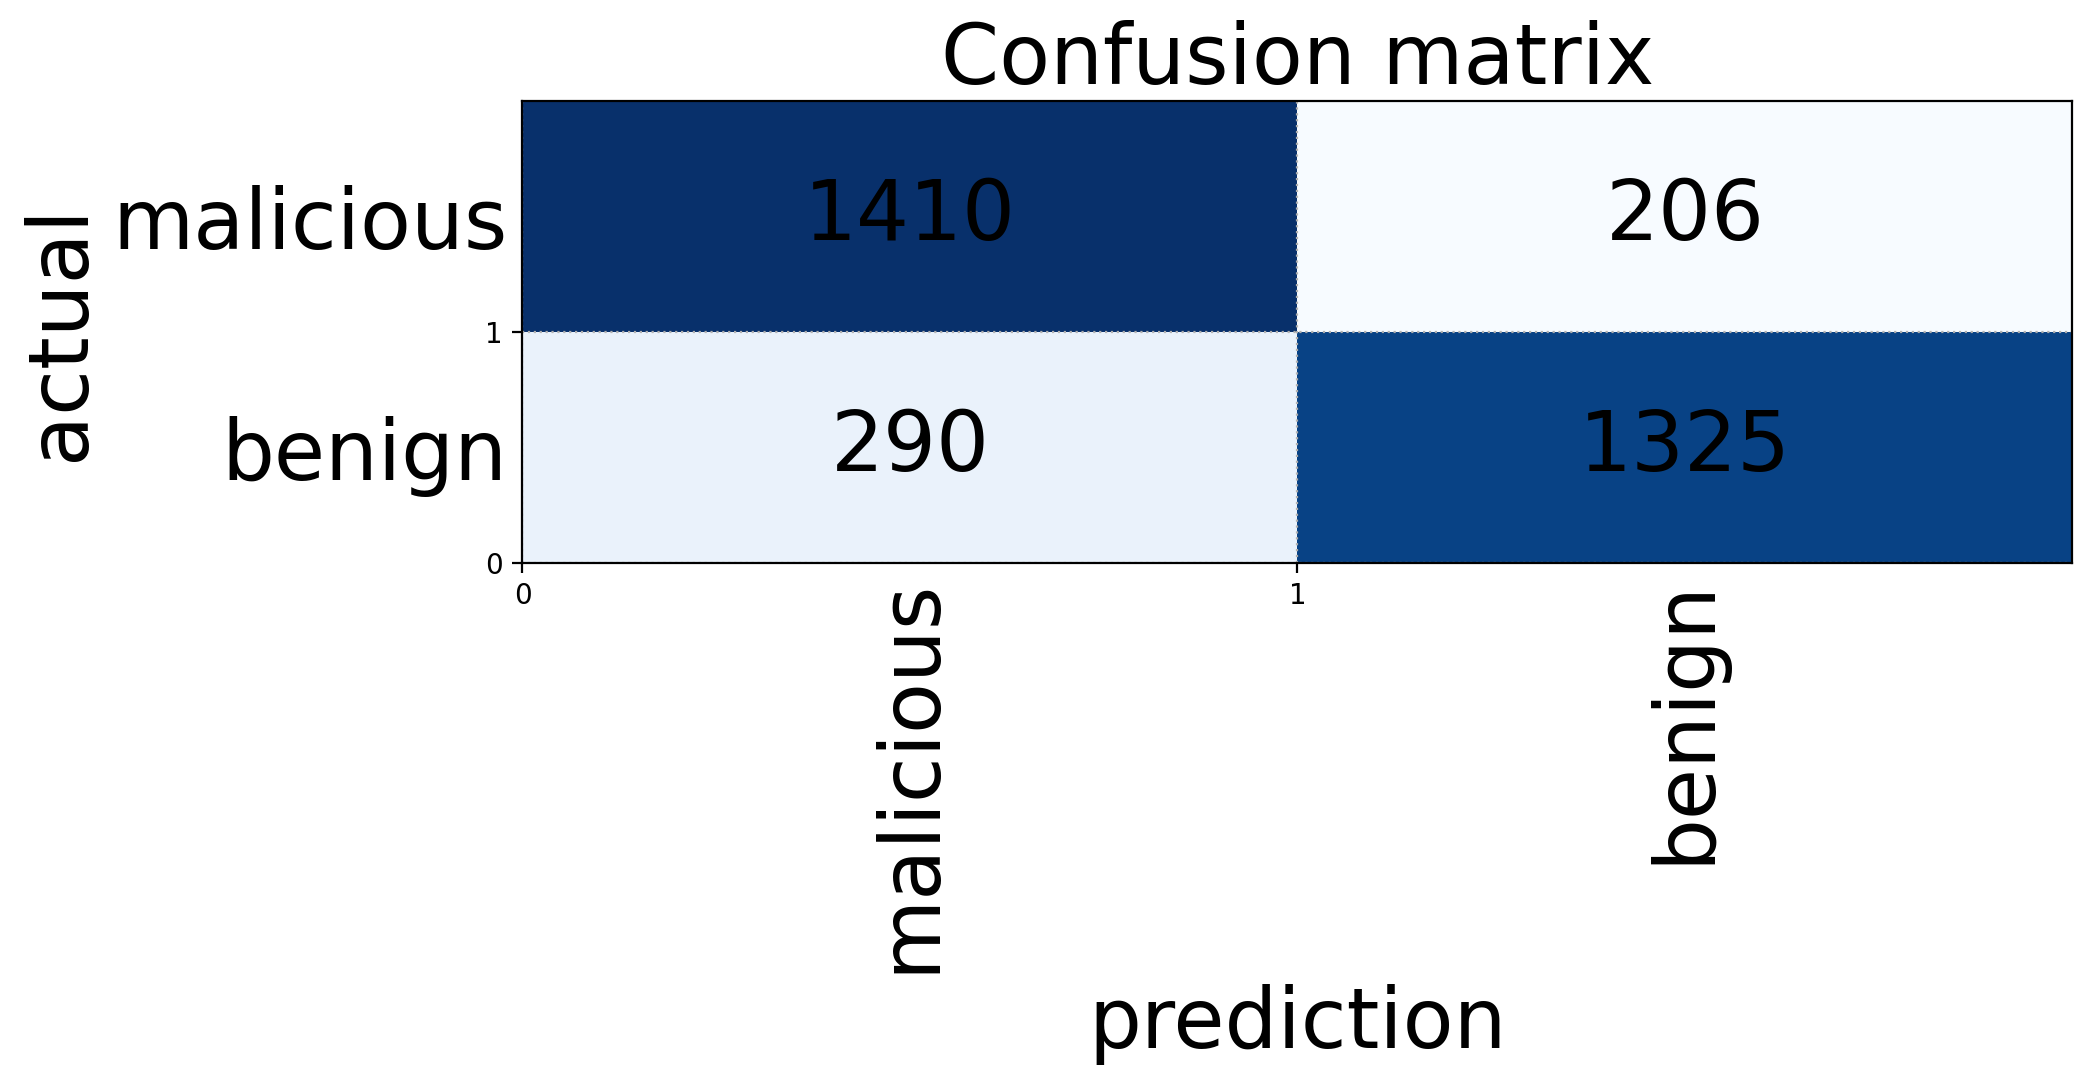

In [17]:
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

confusion = confusion_matrix(train_y, y_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

In [18]:
# Feature(특징)별 가중치 확인
# Logistic Regression은 나중에 해보기 feature_name 속성이 없어서 다른 방법으로 해봐야함
model.coef_

array([[-1.49629774e-04,  1.15536310e+00,  7.42431106e-02,
        -1.61708969e-01, -1.41801013e+00,  1.08142884e+00,
        -6.63788401e-02, -2.48505291e-01,  3.41269270e-02,
         2.05334825e-01, -4.84535594e-02, -2.03513751e-01,
        -3.55430940e-01,  1.34618567e-03, -1.25415486e-01,
         4.30794499e-01,  8.03761656e-01, -2.28737524e-02]])

### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier(max_depth=5, random_state=1)
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result['DecisionTree'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.8919429029112056


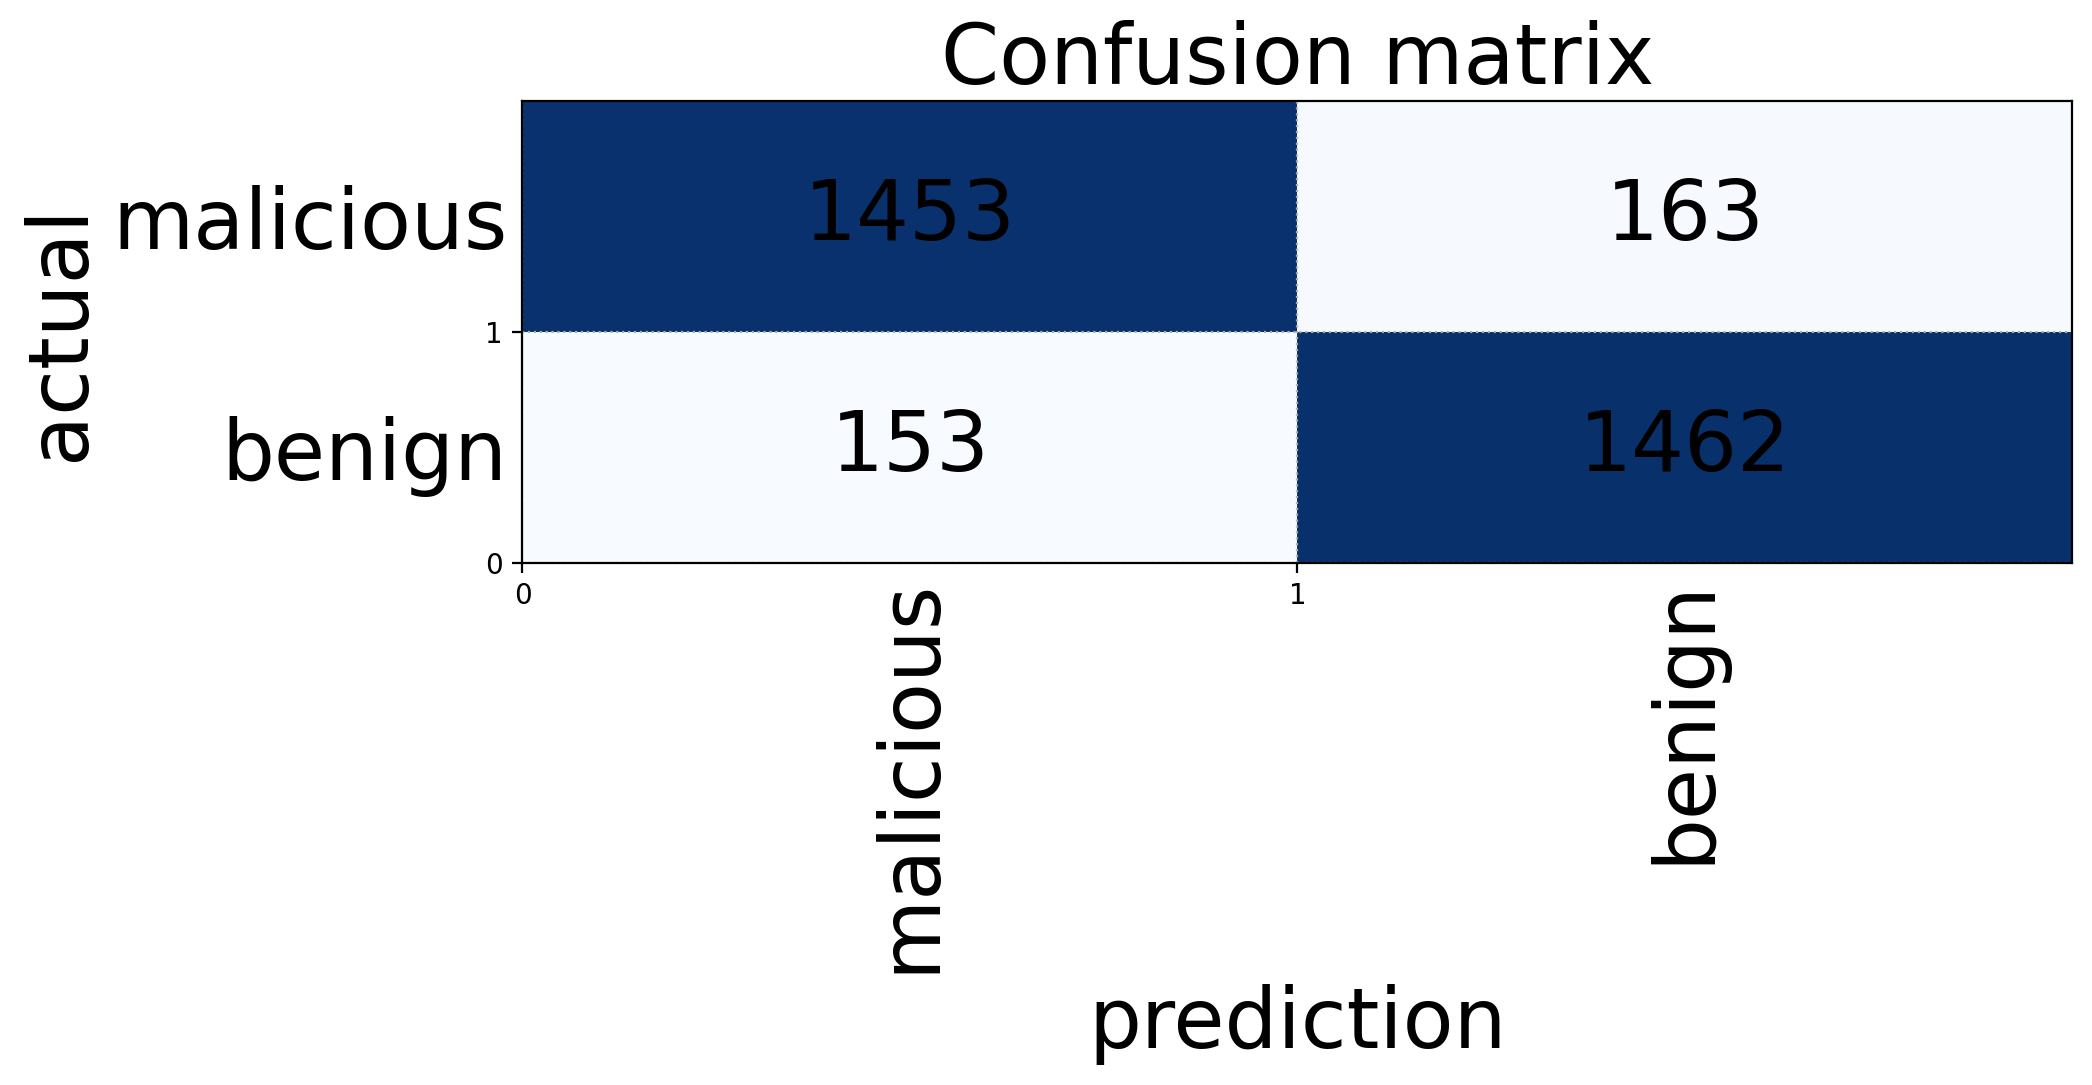

In [21]:
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

confusion = confusion_matrix(train_y, y_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

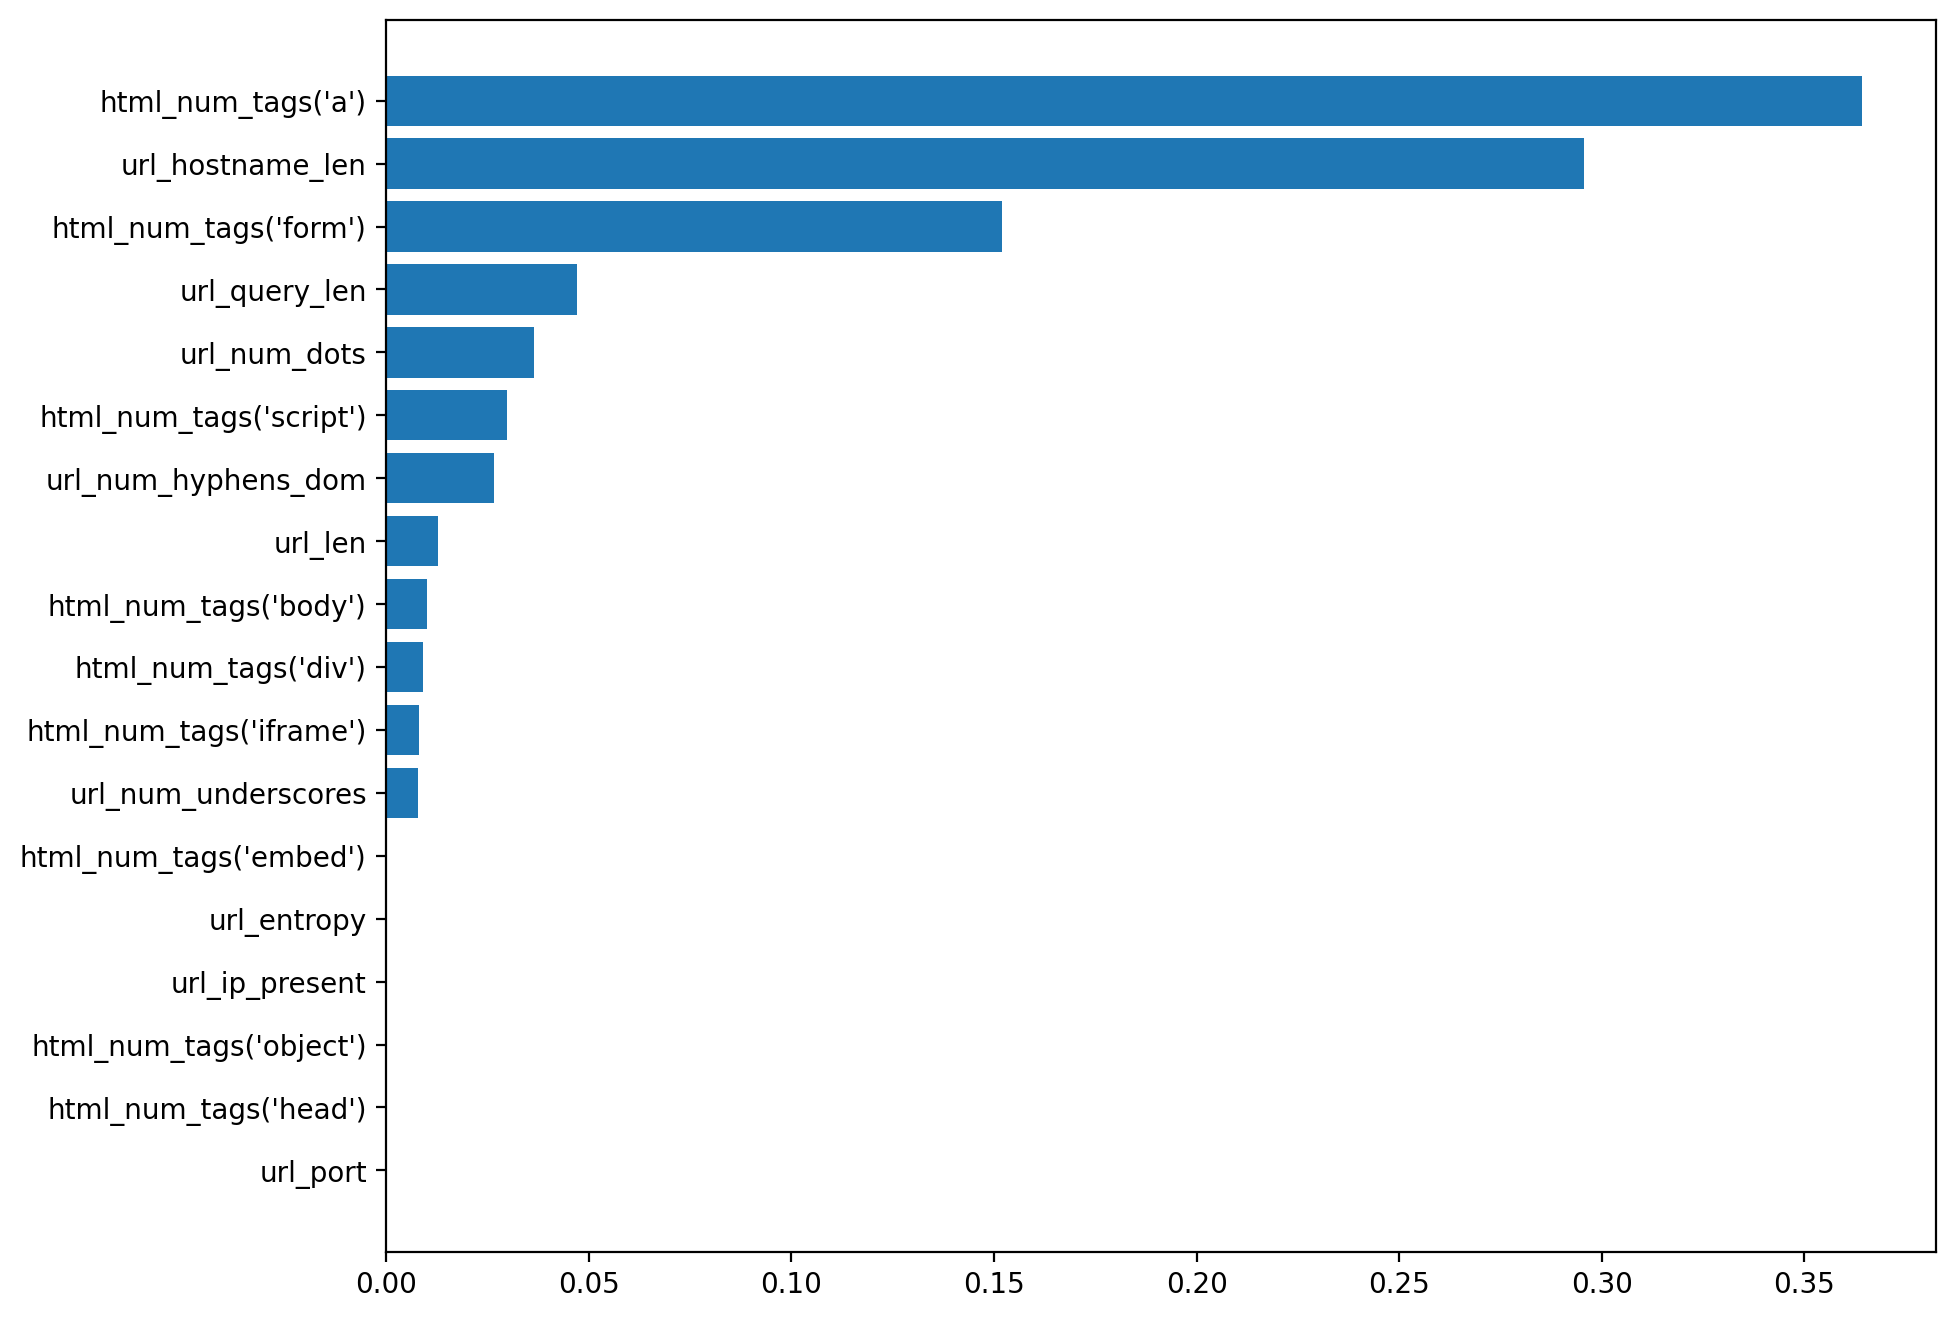

In [22]:
# Feature(특징)별 가중치 확인
# 데이터프레임 만들기 
perf_dic = {'feature':feature_names, 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(df['feature'], df['importance'])
plt.show()

### RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
model = RandomForestClassifier(max_depth=5, random_state=1)
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result['RandomForest'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.9048694551162173


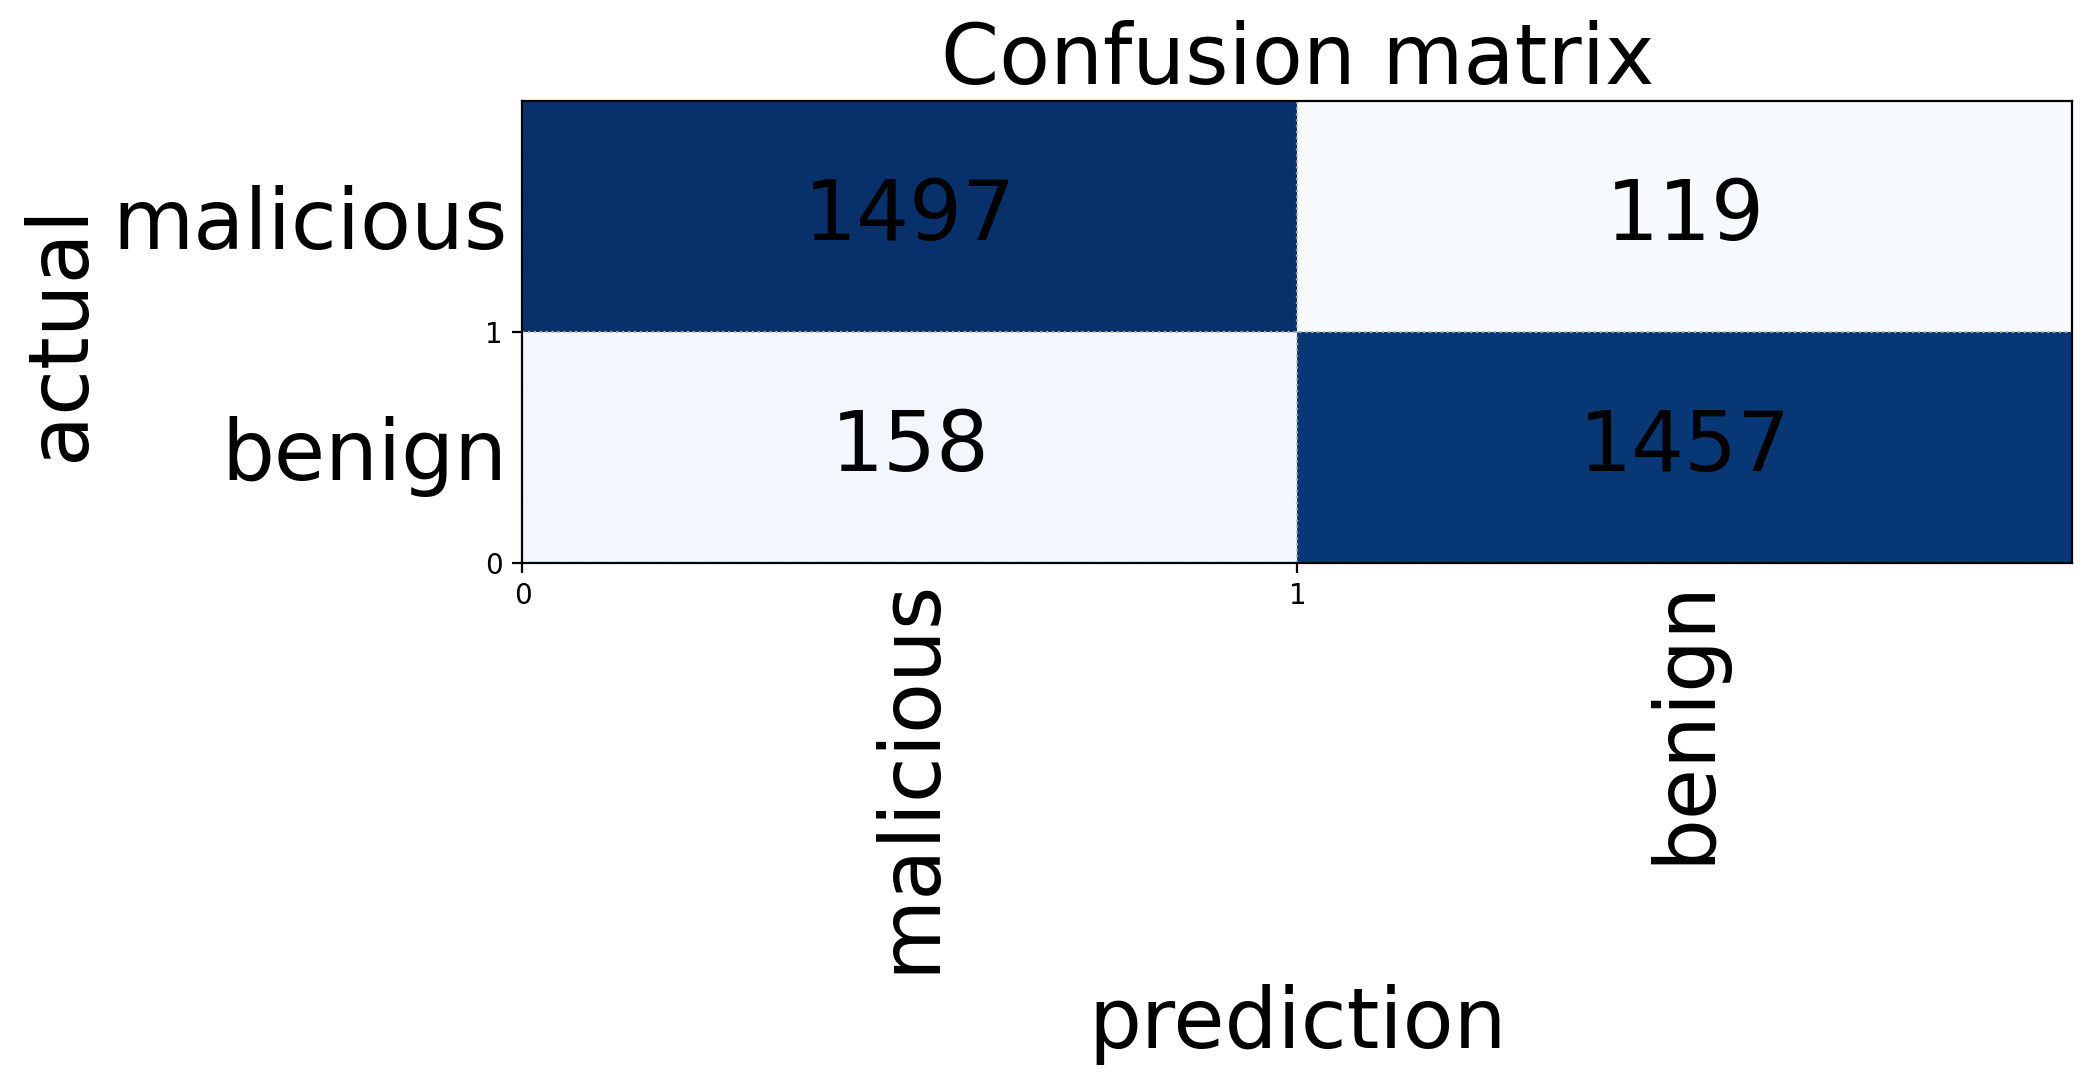

In [25]:
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

confusion = confusion_matrix(train_y, y_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

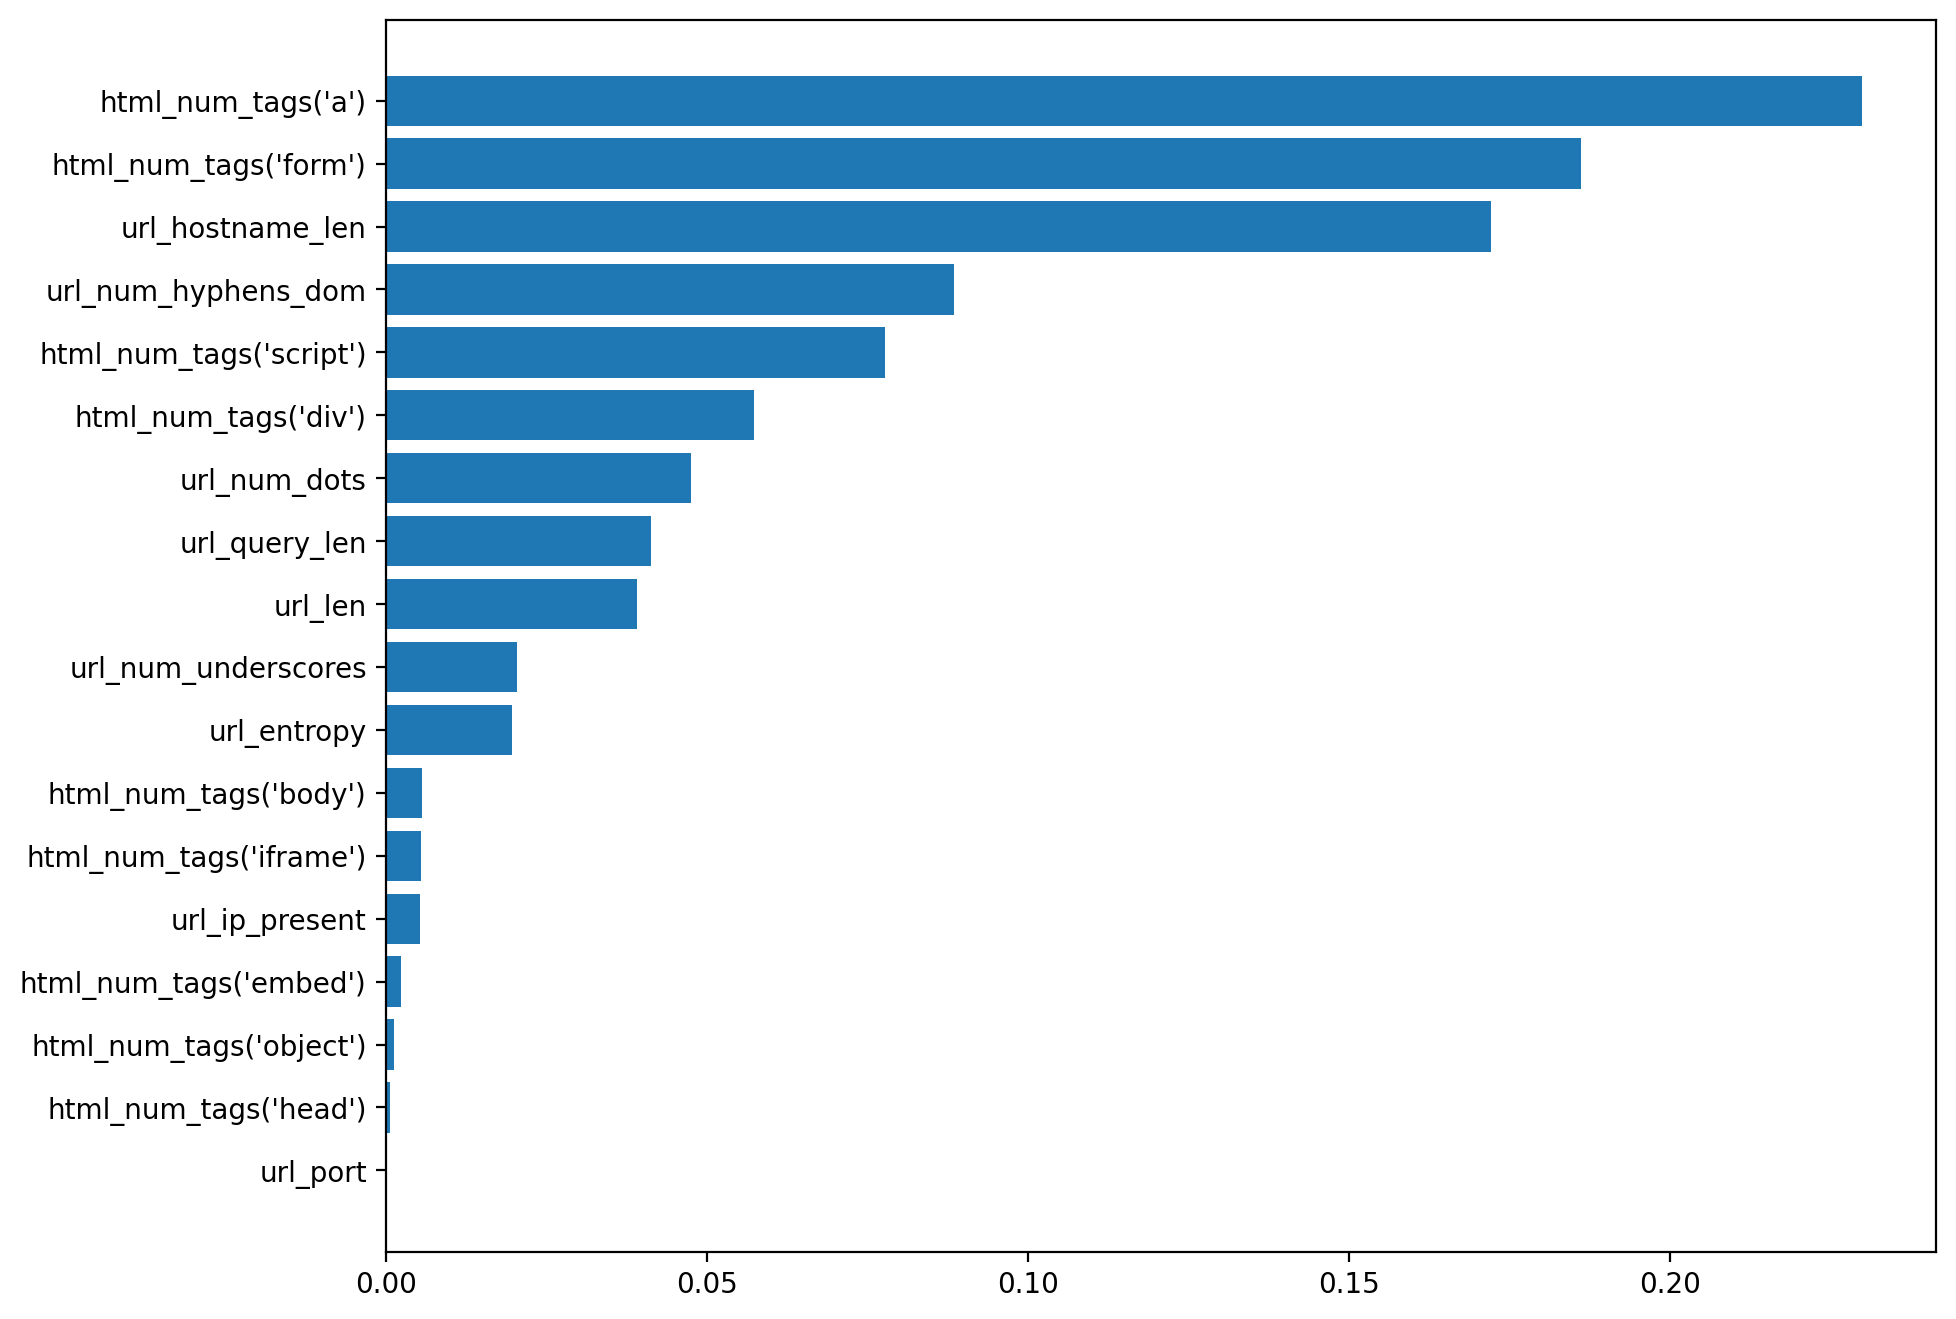

In [26]:
# Feature(특징)별 가중치 확인
# 데이터프레임 만들기 
perf_dic = {'feature':feature_names, 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(df['feature'], df['importance'])
plt.show()

### LightGBM

In [27]:
from lightgbm import LGBMClassifier

In [28]:
model = LGBMClassifier(max_depth=5, random_state=1)
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result['LGBM'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.9377932576341778


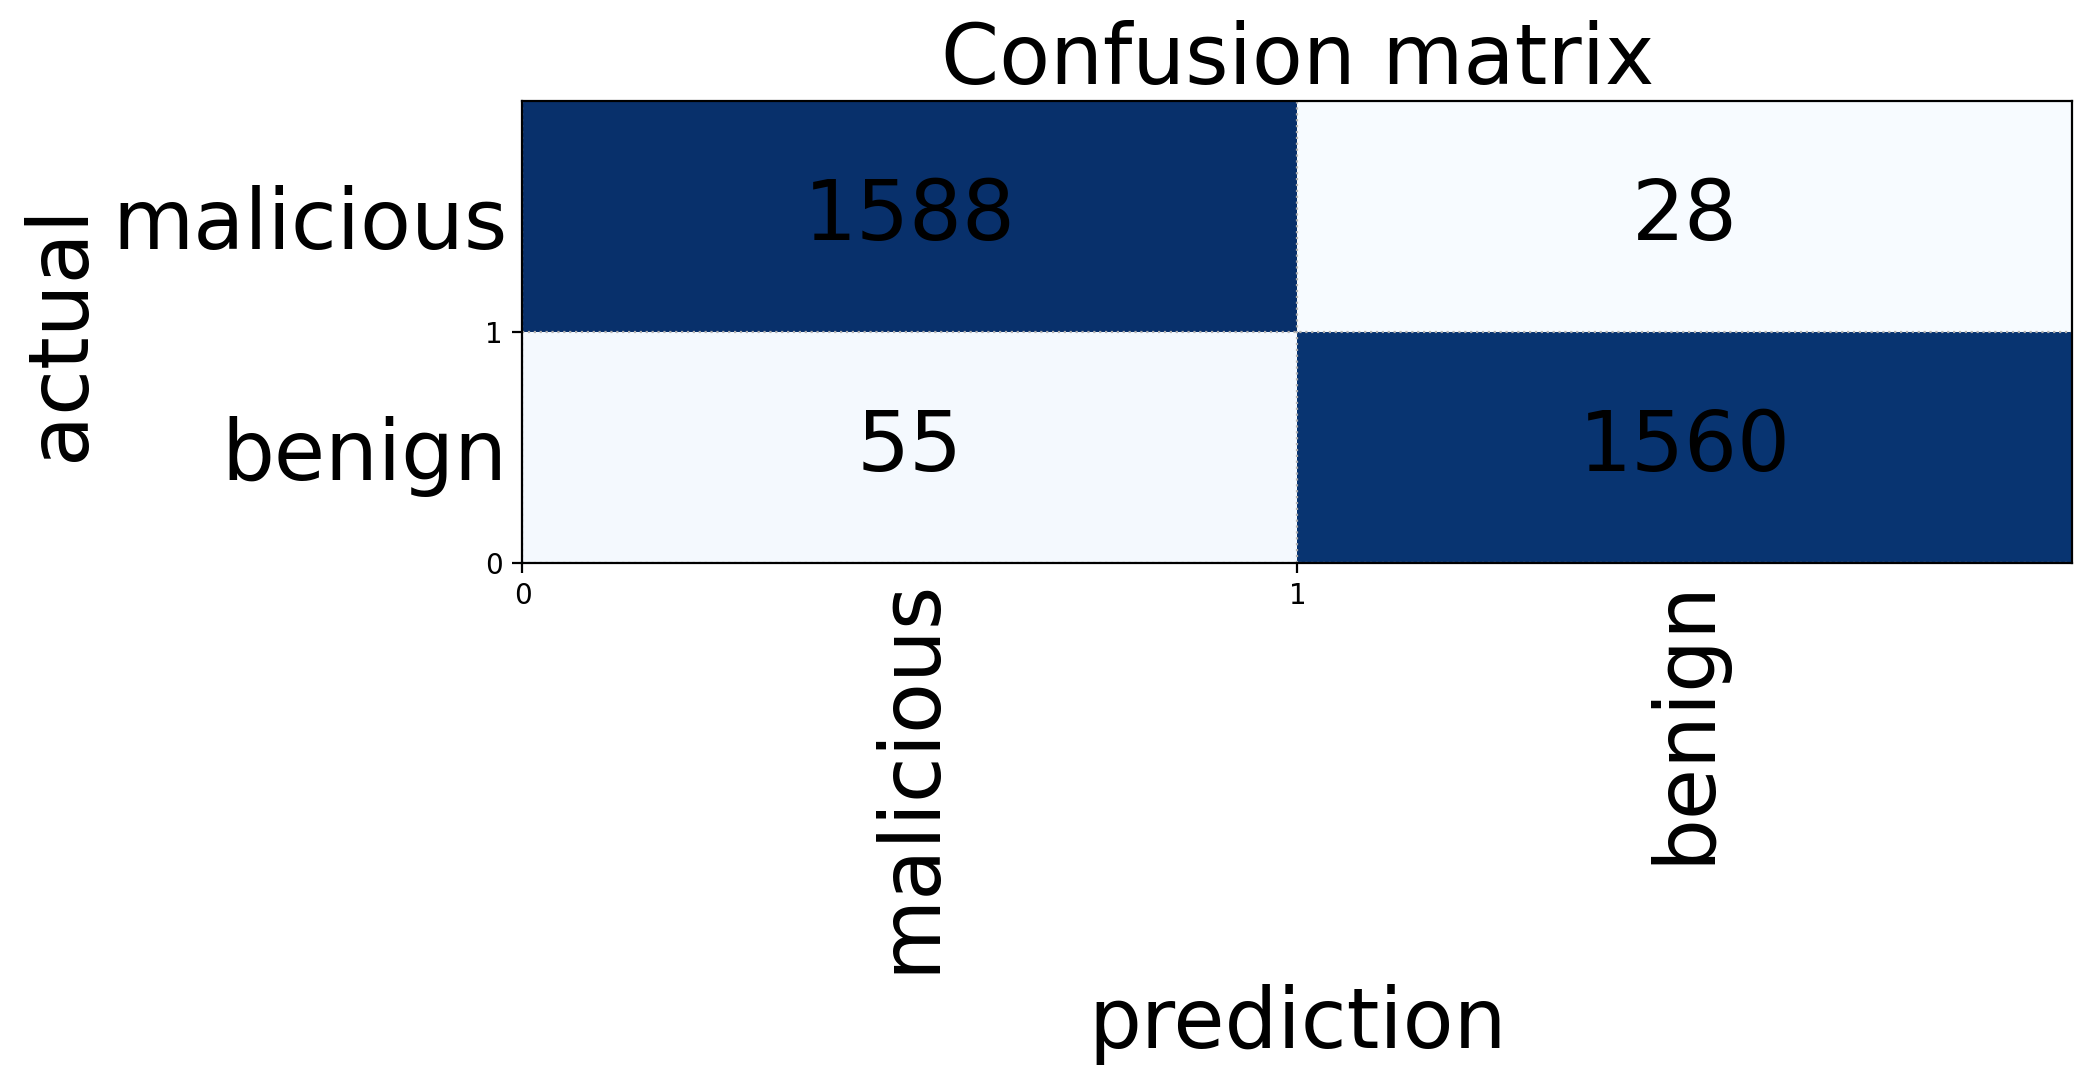

In [29]:
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

confusion = confusion_matrix(train_y, y_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

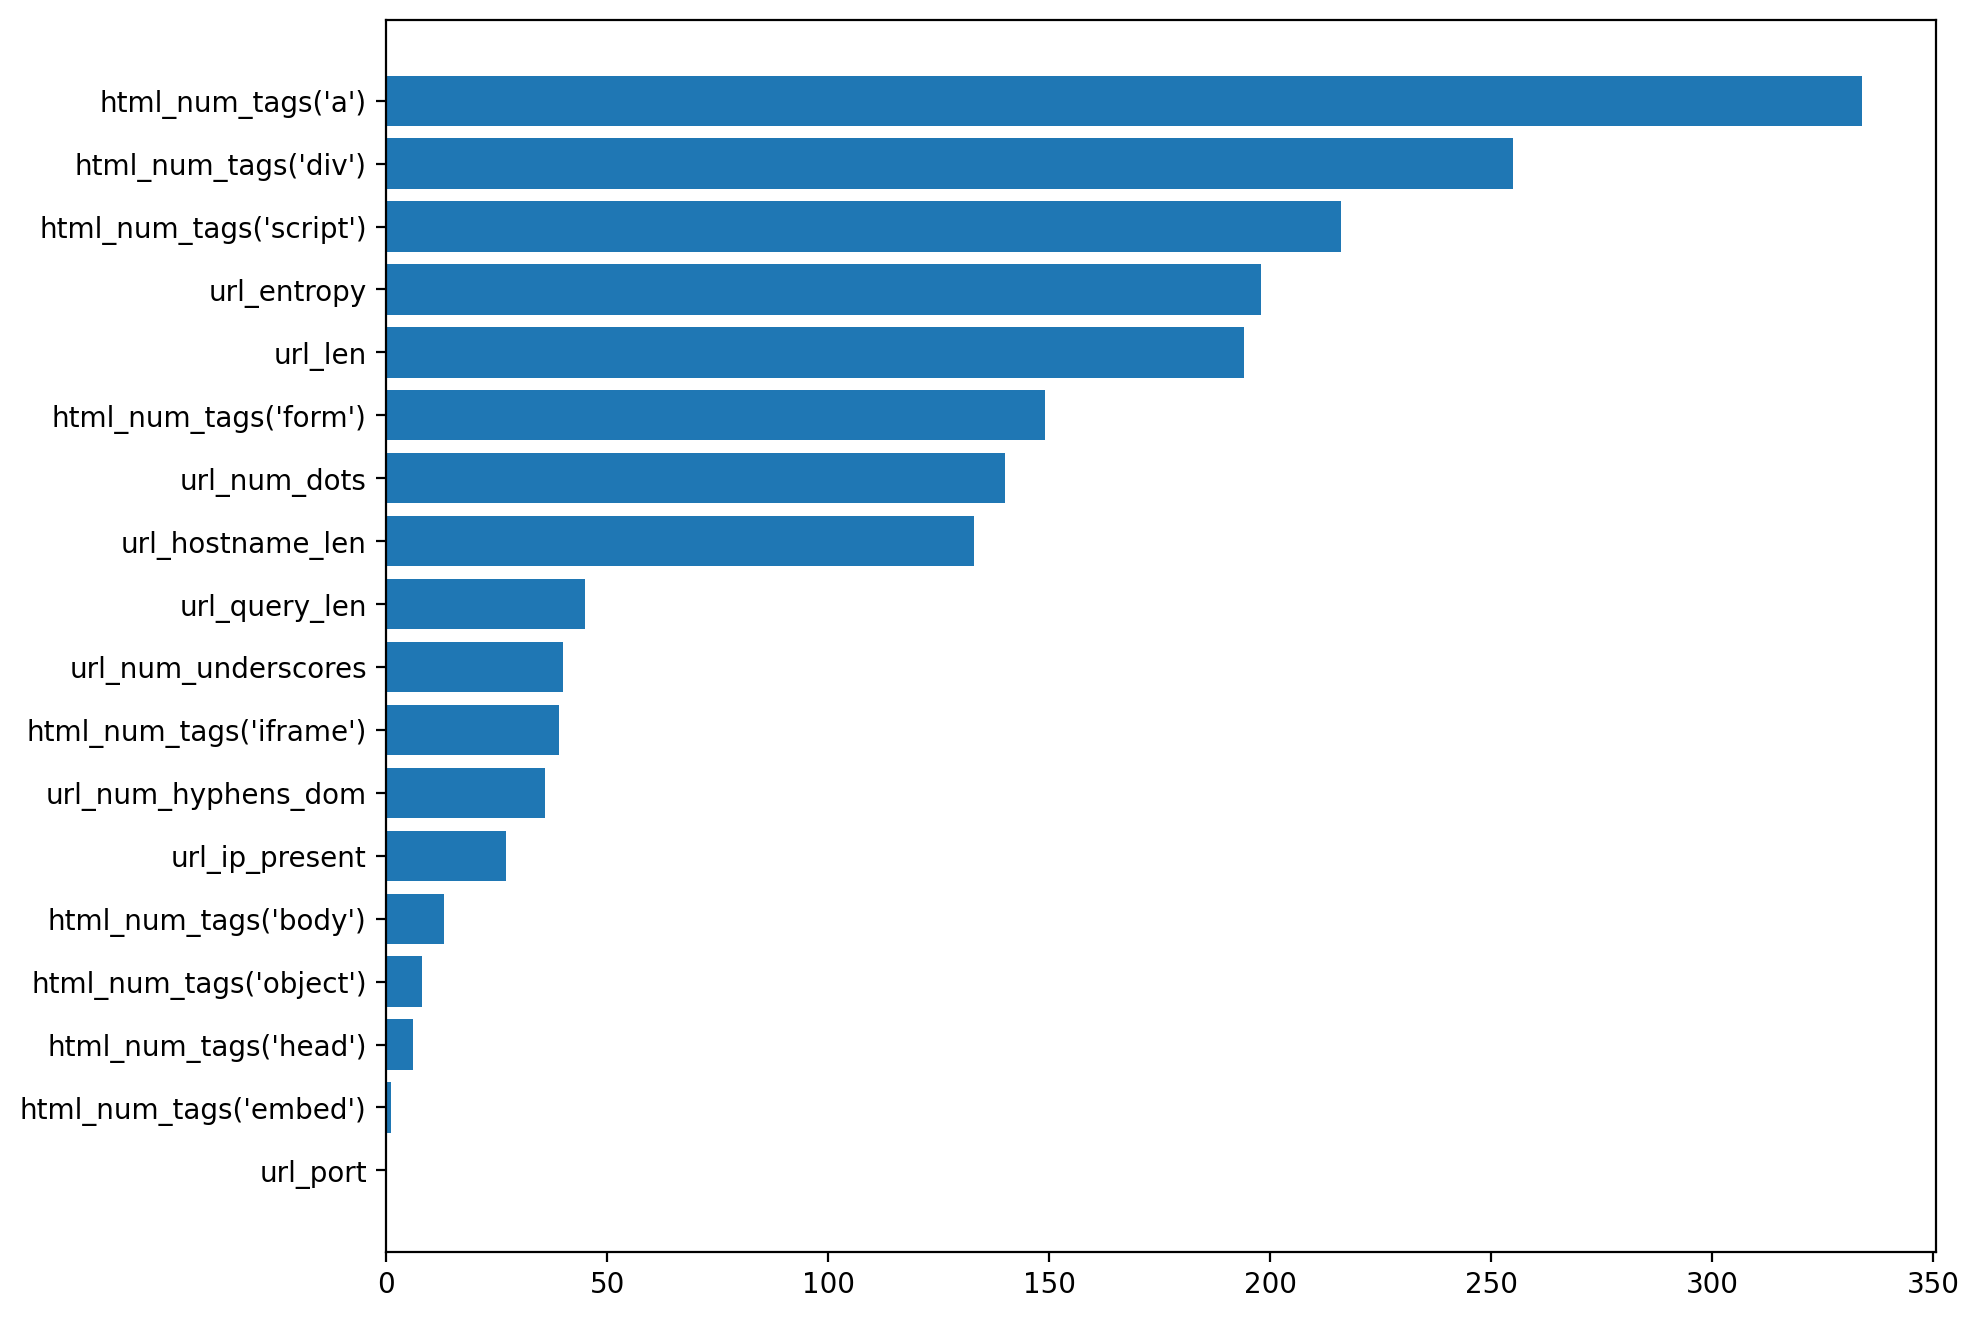

In [30]:
# Feature(특징)별 가중치 확인
# 데이터프레임 만들기 
perf_dic = {'feature':feature_names, 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(df['feature'], df['importance'])
plt.show()

### XGBoost

In [31]:
from xgboost import XGBClassifier

In [32]:
model = XGBClassifier(max_depth=5, random_state=1)
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result['XGB'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.9441914507211372


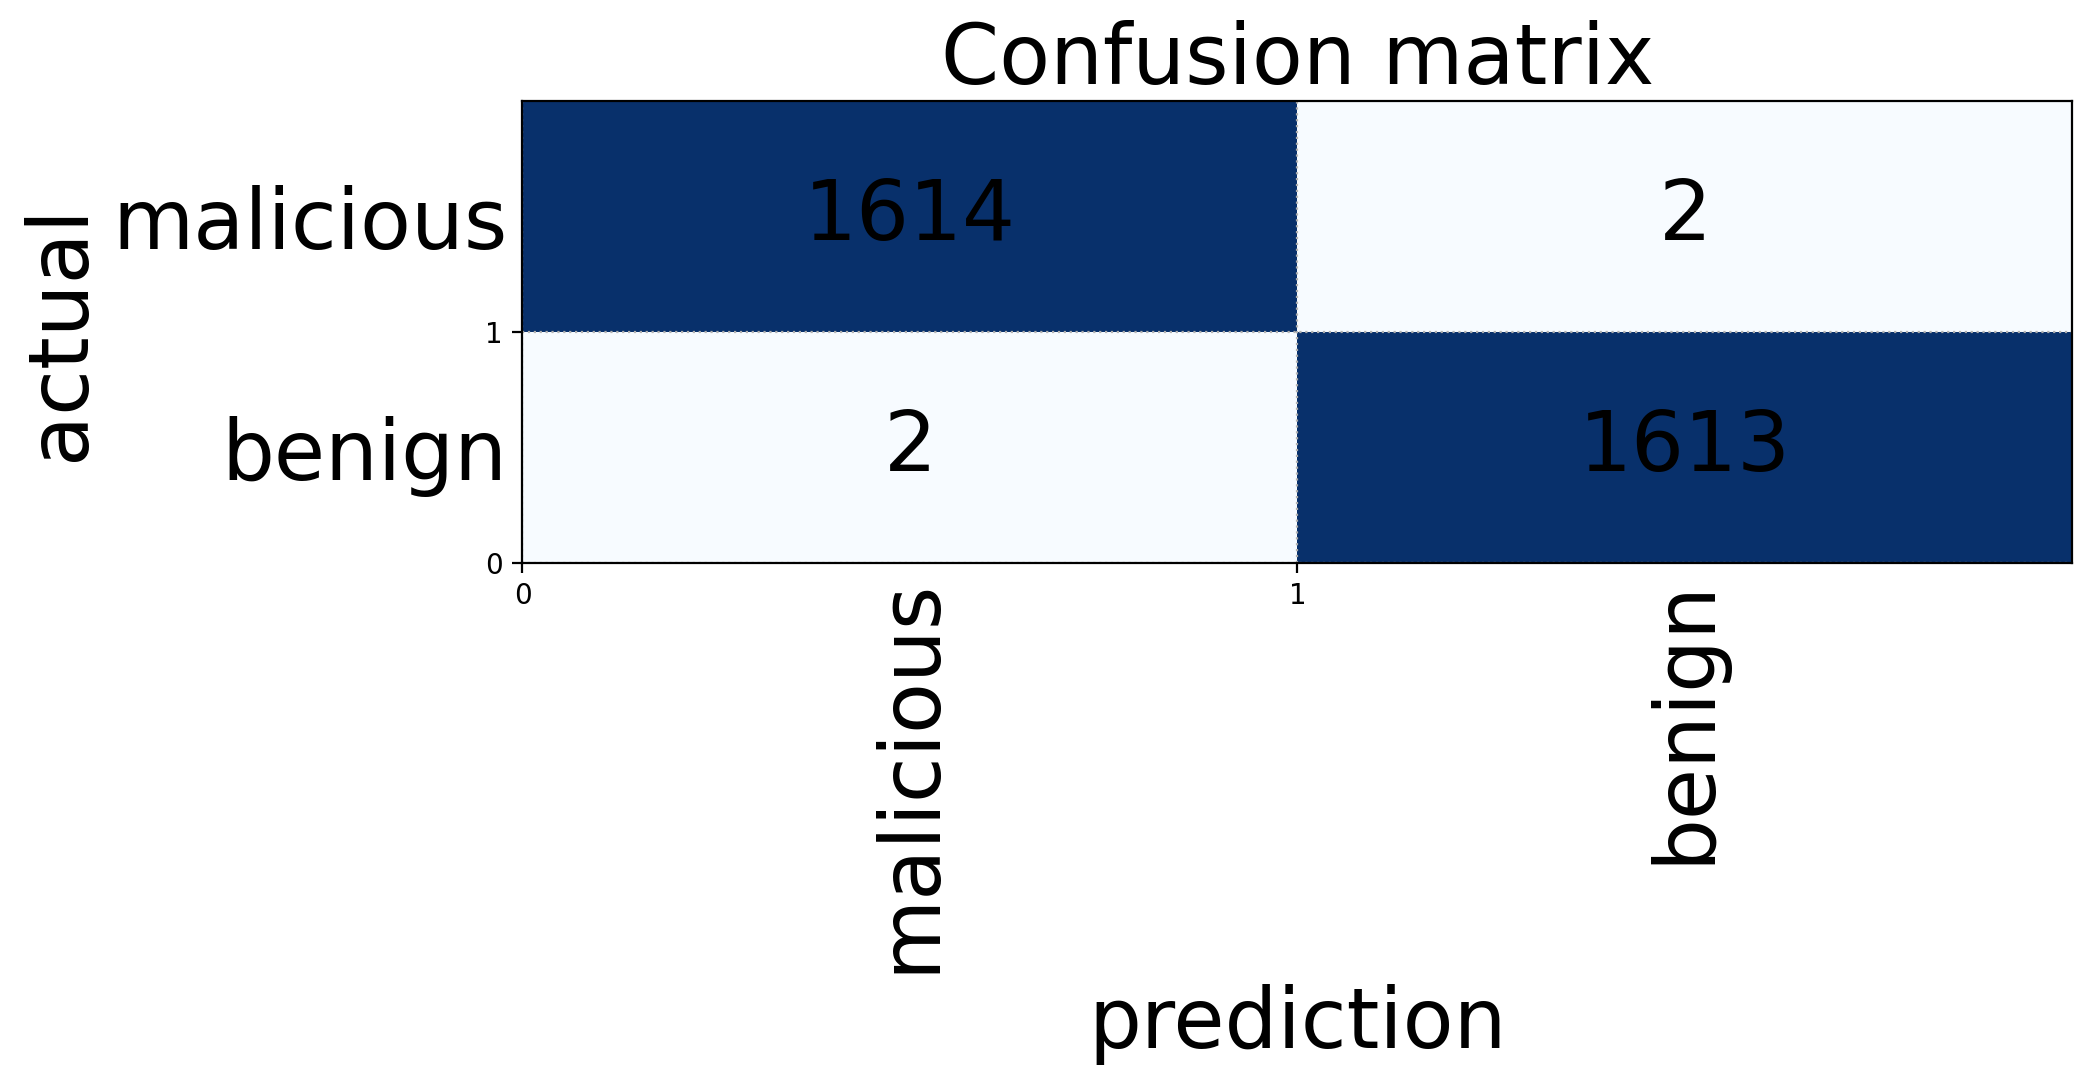

In [33]:
model.fit(train_x, train_y)
y_pred = model.predict(train_x)

confusion = confusion_matrix(train_y, y_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

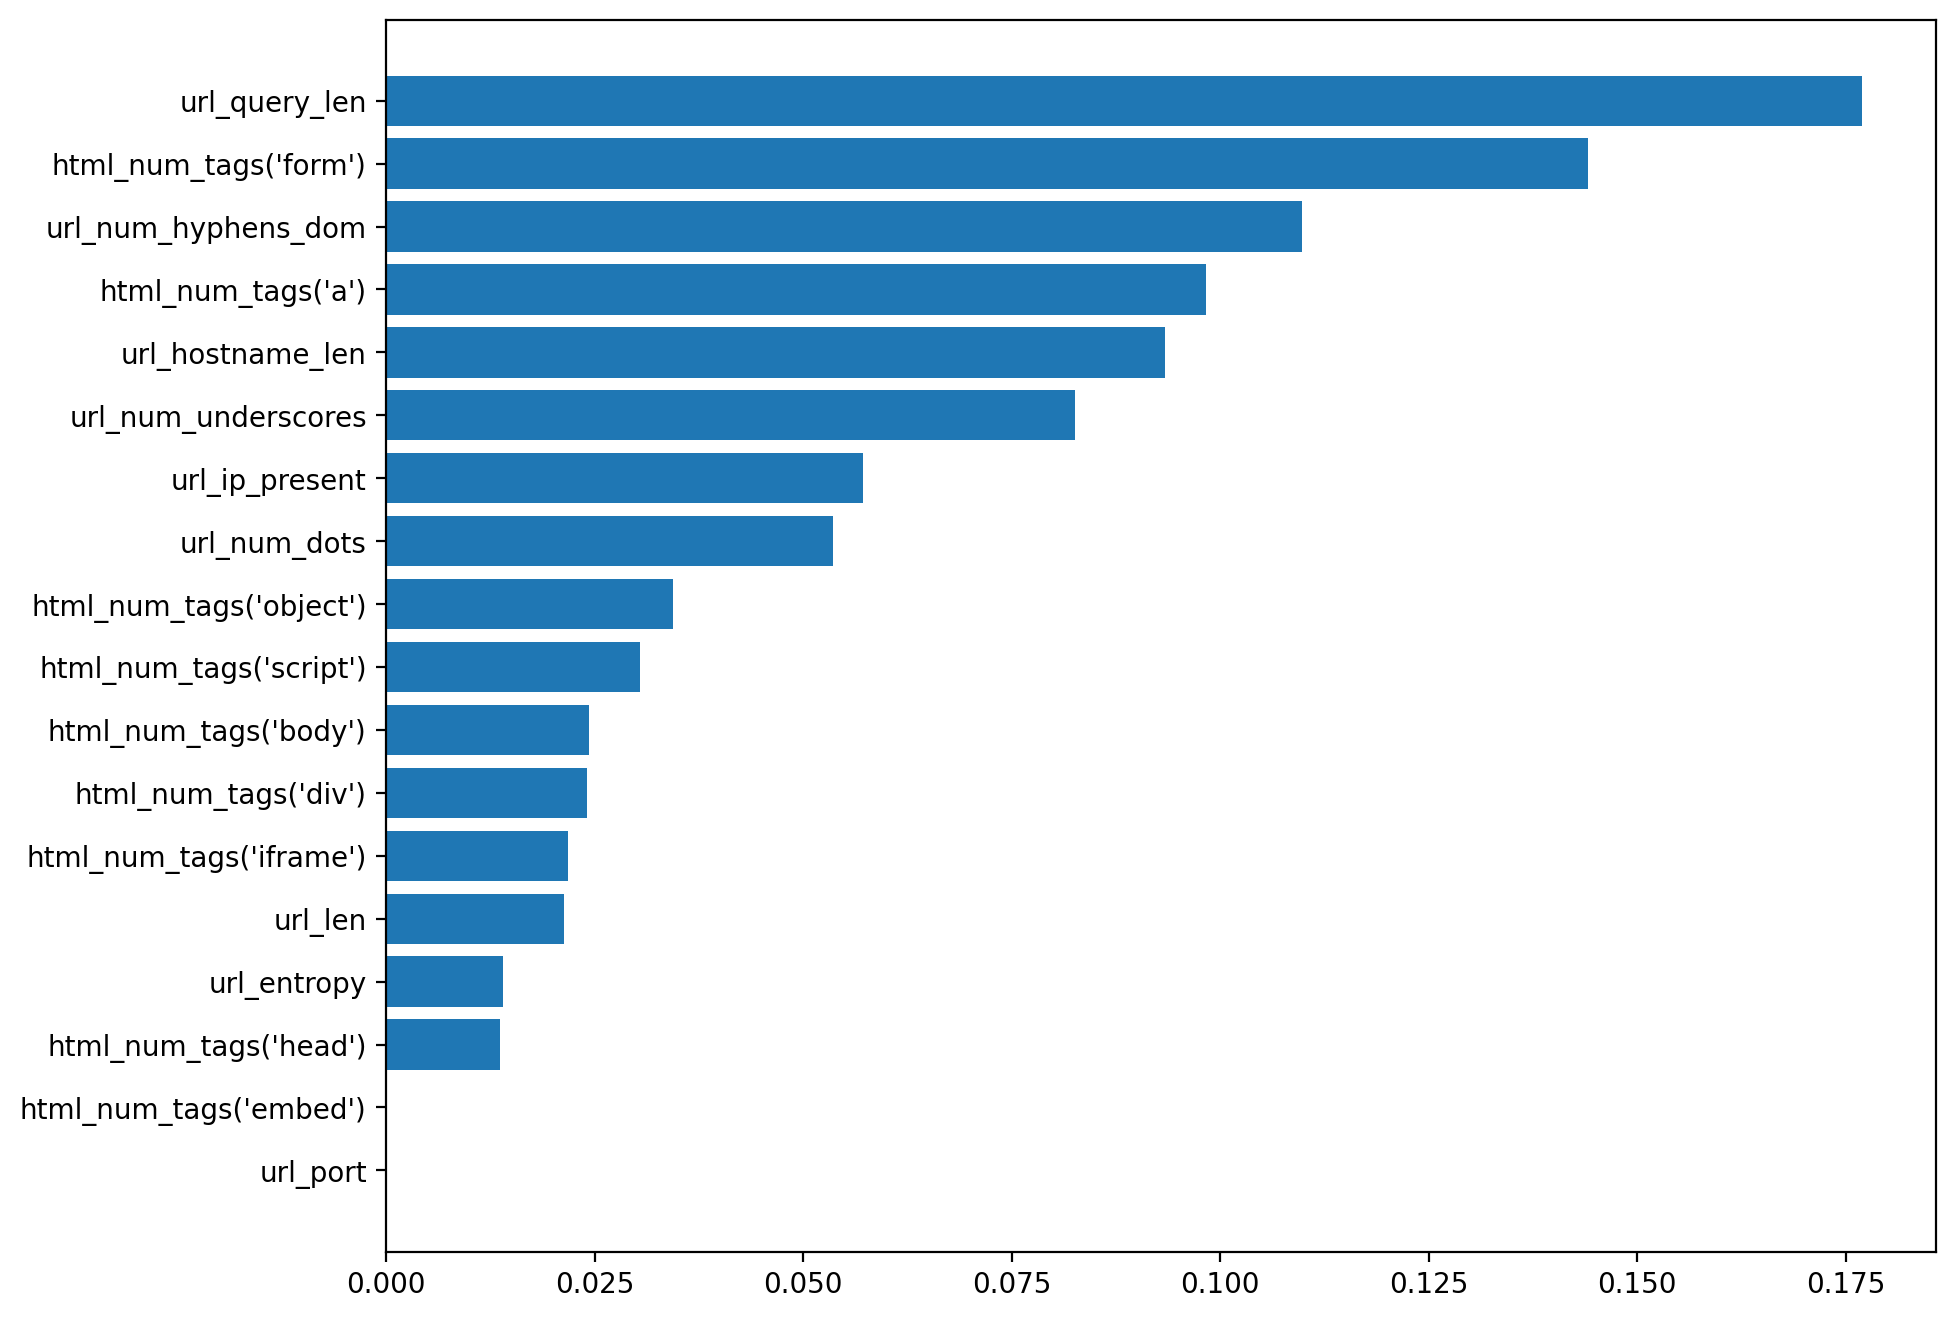

In [34]:
# Feature(특징)별 가중치 확인
# 데이터프레임 만들기 
perf_dic = {'feature':feature_names, 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(df['feature'], df['importance'])
plt.show()

## 예측 성능 비교

In [35]:
cv_result

{'Logistic Regression': 0.8339918022481262,
 'DecisionTree': 0.8919429029112056,
 'RandomForest': 0.9048694551162173,
 'LGBM': 0.9377932576341778,
 'XGB': 0.9441914507211372}

Text(0, 0.5, 'Model')

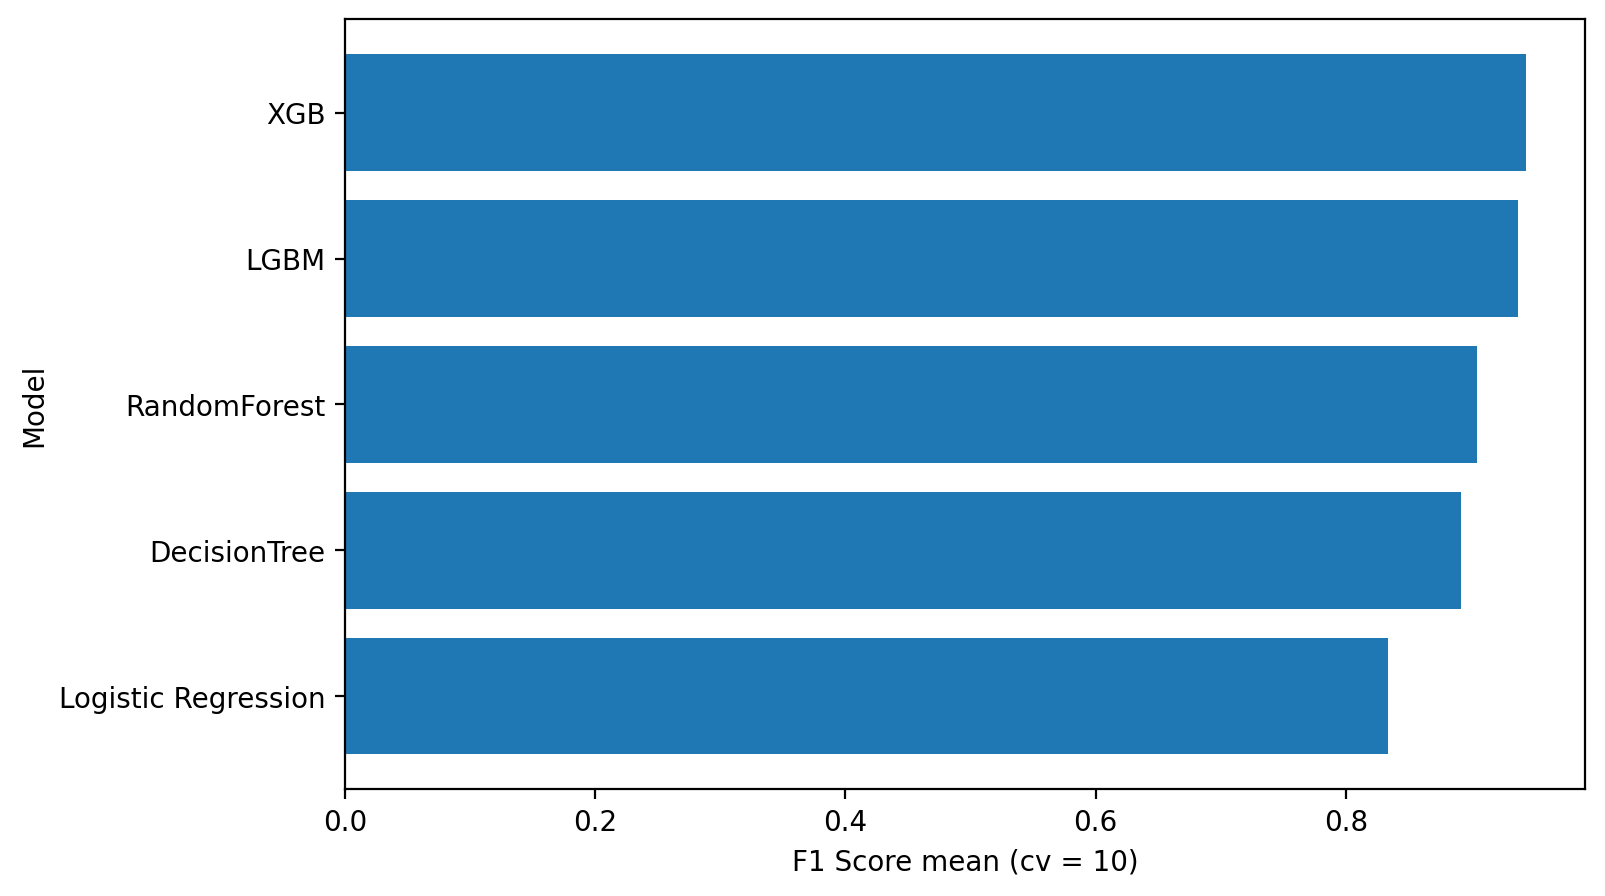

In [36]:
plt.figure(figsize=(8, 5))

plt.barh(list(cv_result), cv_result.values())
plt.xlabel('F1 Score mean (cv = 10)')
plt.ylabel('Model')

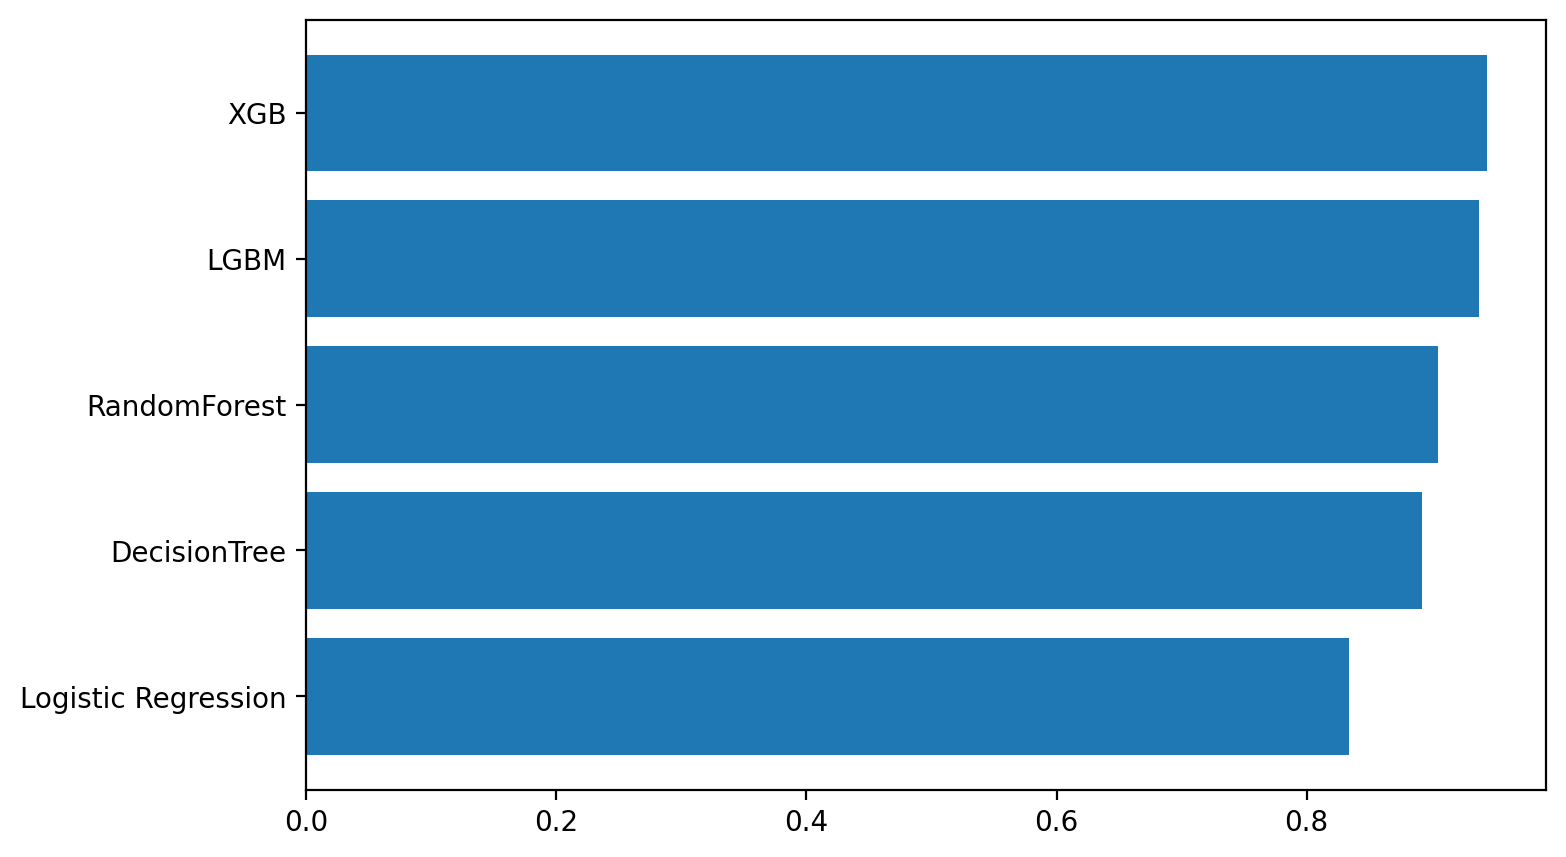

In [37]:
# Feature(특징)별 가중치 확인
# 데이터프레임 만들기 
perf_dic = {'model':list(cv_result), 'cv_score': cv_result.values()}
df = pd.DataFrame(perf_dic)
df.sort_values(by='cv_score', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(df['model'], df['cv_score'])
plt.show()

In [38]:
model = XGBClassifier(max_depth=11, random_state=1)
cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='f1')
cv_result['XGB'] = cv_score.mean()
print("cv score mean :", cv_score.mean())

cv score mean : 0.9456006462890405


In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
model_XGB = XGBClassifier(random_state=1)
param = {
    'max_depth' : range(1, 20)
}
model = GridSearchCV(
    model_XGB,
    param,
    cv=10
)
model.fit(train_x, train_y)
model.best_params_, model.best_score_

({'max_depth': 6}, 0.9476990406298972)

In [41]:
model = XGBClassifier(max_depth = 6, random_state = 1)
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [42]:
test = test_x.drop('id', axis=1)
y_pred = model.predict(test)

In [43]:
# 'benign' : 0, 'malicious' : 1
prediction = np.where(y_pred == 0, 'benign', 'malicious')

In [44]:
pd.DataFrame(data = {"id" : test_x['id'], "label" : prediction}, columns=['id', 'label']).to_csv("prediction_3.csv", index=False)